# The GrabCut Algorithm

The grabcut algorithm addresses the problem of efficient extraction of a foreground object in a complex environment, whose background cannot be trivially subtracted. The result of the algorithm is an alpha-matte, a binary mask which denotes the foreground and background pixels. The algorithm steers clear of estimating transparency values because of the complexity of the problem, and uses a border-matting (edge-softening technique that we do not implement here.

The algorithm builds upon the GraphCut algorithm, iteratively applying the latter along with several other modifications. The algorithm boasts producing delightfully accurate mattes with minimal and very convenient user interaction.

The algorithm works as follows:
- The algorithm, at any point in time, maintains a set of pixels known to be either in the background ($T_B$) or in the foreground ($T_F$). The rest of the pixels, $T_U$ are unknown and are the ones whose $\alpha$ value is to be estimated.
- At any point in time, the algorithm maintains, for every pixel, an $\alpha$ value which indicates whether the pixel $p$ is in the foreground ($\alpha_p=1$) or in the background ($\alpha_p=0$). These are iteratively refined for pixels in $T_U$ and are fixed for the rest.
- Using all the foreground and background pixels (estimated and known) currently, the algorithm estimates two gaussian mixtures, one for the foreground and background respectively. These are used to estimate the *probability* of a pixel being in the background or in the foreground independent of all other pixels. The algorithm also considers the continuity or smoothness between these pixels - neighbouring pixels have a higher probability of having the same alpha label, except at the object boundary.
- The algorithm calculates a Gibbs Energy:  
$$\mathbf{E}(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) = U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) + V(\underline{\alpha}, \mathbf{z})$$  
where $\mathbf{k}$, $\underline{\theta}$, $\mathbf{z}$ refer to the GMM component assignments, the GMM parameters and the pixel values respectively.
- The data term, $U$, calculated as the negative log score of a pixel according the the GMM corresponding to its current $\alpha$ value, summed over all pives, deals with the individual likeness of a pixel to belong to the foreground or the background, while the smoothness term, $V$ deals with continuity between pairs of neighbouring pixels.
$$ V(\underline{\alpha}, \mathbf{z}) = \gamma \sum_{(m, n) \in neighbours}indicate(\alpha_n \neq \alpha_m) e^{-\beta||z_m - z_n||_{2}^{2}} $$
- The algorithm then tries to iteratively minimise this energy using the mincut of a graph, as in graphcut.
- The algorithm further allows the user to refine the results by marking pixels as foreground or background again, following which, the energy minimisation is rerun once using the last estimated GMMs. **Optionally, the algorithm allows the entire iterative minimisation to be repeated - which is what we implement here, preferring accuracy  over runtime.**

## Implementation Details
- We use eight-connectivity by default, calculating $\beta$ as the inverse of twice the average of $||z_m - z_n||_{2}^{2}$ over all edges in the graph (neighbouring pixels).
- The capacity of edges connecting known foreground pixels to the source and known background pixels to the sink is set to $9$ times the value of $\gamma$, ensuring that it is large enough (for both four- and eight- connectivity) for the edge to never get cut.
- We skip the indicator term from the smoothness energy, allowing all neighbouring pixels to be connected, irrespective of whether they are at the object boundary or not. This improves results by allowing pixels in the internal regions of the object to force neighbouring pixels towards itself.
- As stated above, we rerun the entire iterative optimisation again after user refinement (which is optional according to the original algorithm), favouring accuracy over runtime.
- By default, we use $\gamma=50$ and $3$ iterations of grabcut, with a tolerance of change for the mincut value.

In [1]:
import numpy as np
import cv2
from collections import namedtuple
from sklearn.mixture import GaussianMixture
import logging
import sys
from tqdm.auto import tqdm as tq

logging.basicConfig(stream=sys.stdout, level=logging.WARN)

# Constants
con = namedtuple('_', ('FIX', 'UNK', 'FG', 'BG'))(1, 0, 1, 0)
NUM_GMM_COMP = 5
GAMMA = 50
LAMDA = 9 * GAMMA
NUM_ITERS = 3
TOL = 1e-3

def fit_gmms(img, alphas, n_components):
    """Fit Gaussian Mixture Models to foreground and background regions"""
    fg = GaussianMixture(n_components=n_components)
    fg.fit(img[alphas == con.FG].reshape((-1, img.shape[-1])))

    bg = GaussianMixture(n_components=n_components)
    bg.fit(img[alphas == con.BG].reshape((-1, img.shape[-1])))

    return fg, bg

def graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda, connect_diag):
    """Perform graph cut optimization"""
    logging.info('GRAPH CUT')
    
    # Compute region energy
    fg_D = - fg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    bg_D = - bg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])

    def compute_V(i, j, oi, oj):
        diff = img[i, j] - img[oi, oj]
        return gamma * np.exp(- beta * diff.dot(diff))

    fix_cap = lamda
    num_pix = img.shape[0] * img.shape[1]

    def vid(i, j):
        return (img.shape[1] * i) + j

    def ind(idx):
        return ((idx // img.shape[1]), (idx % img.shape[1]))
    
    import igraph as ig
    graph = ig.Graph(directed=False)
    graph.add_vertices(num_pix + 2)
    S = num_pix
    T = num_pix + 1

    edges = []
    weights = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if types[i, j] == con.FIX:
                if alphas[i, j] == con.FG:
                    edges.append((vid(i, j), S))
                    weights.append(fix_cap)
                else:
                    edges.append((vid(i, j), T))
                    weights.append(fix_cap)
            else:
                edges.append((vid(i, j), S))
                weights.append(bg_D[i, j])
                edges.append((vid(i, j), T))
                weights.append(fg_D[i, j])
            
            # Add edges to neighbours
            if i > 0:
                edges.append((vid(i, j), vid(i-1, j)))
                weights.append(compute_V(i, j, i-1, j))
            
            if j > 0:
                edges.append((vid(i, j), vid(i, j-1)))
                weights.append(compute_V(i, j, i, j-1))

            if connect_diag:
                if i > 0 and j > 0:
                    edges.append((vid(i, j), vid(i-1, j-1)))
                    weights.append(compute_V(i, j, i-1, j-1))
                if i > 0 and j < img.shape[1] - 1:
                    edges.append((vid(i, j), vid(i-1, j+1)))
                    weights.append(compute_V(i, j, i-1, j+1))
    
    graph.add_edges(edges, attributes={'weight': weights})
    cut = graph.st_mincut(S, T, capacity='weight')
    bg_vertices = cut.partition[0]
    fg_vertices = cut.partition[1]
    if S in bg_vertices:
        bg_vertices, fg_vertices = fg_vertices, bg_vertices
    
    new_alphas = np.zeros(img.shape[:2], dtype=np.uint8)
    for v in fg_vertices:
        if v not in (S, T):
            new_alphas[ind(v)] = 1
    return cut.value, new_alphas

def grab_cut_three_level(img, mask, n_components=NUM_GMM_COMP, gamma=GAMMA, 
                        lamda=LAMDA, num_iters=NUM_ITERS, tol=TOL, connect_diag=True):
    """
    Perform GrabCut segmentation using a three-level mask input.
    
    Parameters:
    -----------
    img : numpy.ndarray
        Input image (H x W x 3)
    mask : numpy.ndarray
        Three-level mask (H x W) with values:
        0 - definite background
        128 - probable background
        255 - definite/probable foreground
    
    Returns:
    --------
    mask : numpy.ndarray
        Binary segmentation mask (H x W)
    """
    logging.info('GRAB CUT WITH THREE-LEVEL MASK')
    img = img.astype(np.float32)
    
    # Initialize types and alphas from mask
    types = np.zeros(mask.shape, dtype=np.uint8)  # Initialize all as unknown
    alphas = np.zeros(mask.shape, dtype=np.uint8)  # Initialize all as background
    
    # Set definite background (0)
    definite_bg = (mask == 0)
    types[definite_bg] = con.FIX
    alphas[definite_bg] = con.BG
    
    # Set probable background (128)
    probable_bg = (mask == 128)
    types[probable_bg] = con.UNK  # Unknown type
    alphas[probable_bg] = con.BG  # Initially background
    
    # Set foreground regions (255)
    foreground = (mask == 255)
    types[foreground] = con.UNK  # Part will be probable (unknown type)
    alphas[foreground] = con.FG  # Initially foreground
    
    # Calculate beta
    logging.info('CALC BETA')
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                diff = img[i, j] - img[i-1, j]
                beta += diff.dot(diff)
            if j > 0:
                diff = img[i, j] - img[i, j-1]
                beta += diff.dot(diff)
            if connect_diag:
                if i > 0 and j > 0:
                    diff = img[i, j] - img[i-1, j-1]
                    beta += diff.dot(diff)
                if i > 0 and j < img.shape[1] - 1:
                    diff = img[i, j] - img[i-1, j+1]
                    beta += diff.dot(diff)

    if connect_diag:
        beta /= (4 * img.shape[0] * img.shape[1] - 3 * img.shape[0] - 3 * img.shape[1] + 2)
    else:
        beta /= (2 * img.shape[0] * img.shape[1] - img.shape[0] - img.shape[1])
    beta *= 2
    beta = 1 / beta
    
    # Iterative optimization
    prev_flow = -1
    for _ in tq(range(num_iters)):
        fg_gmm, bg_gmm = fit_gmms(img, alphas, n_components)
        flow, alphas = graph_cut(img, types, alphas, fg_gmm, bg_gmm, beta, gamma, lamda, connect_diag)
    
        if prev_flow != -1 and abs(prev_flow - flow) < tol:
            break
        
        prev_flow = flow
    
    logging.info('DONE')
    return alphas

  0%|          | 0/3 [00:00<?, ?it/s]

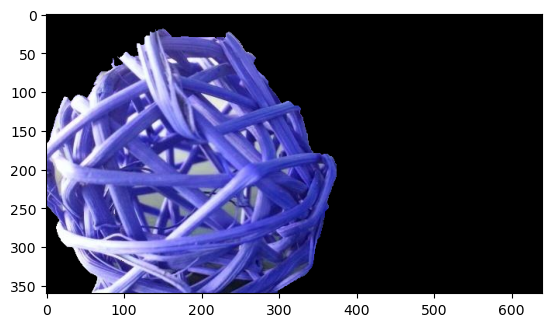

In [3]:
import matplotlib.pyplot as plt
img_path = r"D:\AVWS\Results\balls\results\balls.jpg"
mask_path = r"D:\AVWS\Results\balls\results\trimap.jpg"

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


# Perform segmentation
result_mask = grab_cut_three_level(img, mask)

# Create output
output = cv2.bitwise_and(img, img, mask=result_mask.astype(np.uint8) * 255)

plt.imshow(output)


Here, we vary different parameters to see their effect on the performance of the algorithm qualitatively (due to the absence of ground truth segmentation masks required for any quantitative analysis), which, for this specific problem, easily gives a very good idea of the performance of the algorithm. It is evident from the start that the algorithm can handle some very challenging situations (such as noisy backgrounds and foregrounds) really well, even in just a few iterations and with imperfect user input.

## Effect of Parameters and Variations

### Effect of $\gamma$
$\gamma$ weights the boundary edges against the region edges. A larger $\gamma$ makes it harder for boundary edges to be cut, placing more importance on continuity over the individual susceptibility of a pixel to belong to the foreground or background. Here, we run the algorithm with $\gamma$ set to $50$ on the higher side and $1$ on the lower side on the image.

  0%|          | 0/3 [00:00<?, ?it/s]

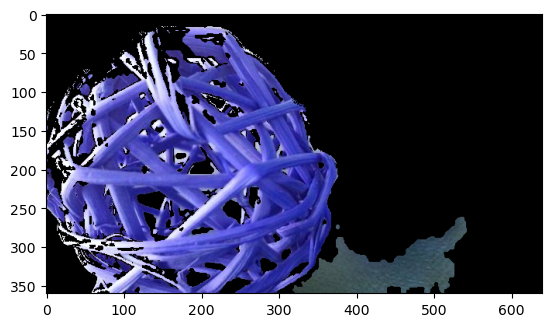

In [4]:
result_mask = grab_cut_three_level(img, mask, gamma=1)
output = cv2.bitwise_and(img, img, mask=result_mask.astype(np.uint8) * 255)

plt.imshow(output)

Here, we notice that in the second run, a lot of the background which is *similarily coloured as the subject,* is labelled as the foreground. This is because by setting $\gamma=1$, we lower the weight of the boundary edges, letting them be easily cut. This places more importance on the individual resemblance of a pixel to the mainstream foreground and background colours - allowing parts of the background similarily coloured as the object to be classified as the foreground - even though they are discontinuously placed.